In [1]:
%pip install astropy


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# coding: utf-8
%matplotlib notebook
import copy
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences
from scipy import interpolate
#import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy import optimize
from astropy.timeseries import LombScargle
import glob
from matplotlib import rc, rcParams

In [3]:
rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 6
rcParams['grid.linestyle'] = '--'
rcParams['axes.titlepad'] = 20
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.right'] = True
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'
rc('legend', fontsize=15)
rc('xtick.major', size=5, width=1.5)
rc('ytick.major', size=5, width=1.5)
rc('xtick.minor', size=3, width=1)
rc('ytick.minor', size=3, width=1)

In [6]:
filename = '/media3/majumder/zwaad/zwad/slsn_data/ZTF_Fields.txt'
#Open the file
infile = open(filename, 'r')

lines = infile.readlines()
fields = np.ones((1778, 9))
ind=0
print(len(lines))
for l in range(1,len(lines)):
    # print(l)
    # for line in lines:
    line = lines[l]
    sline = line.split()
    # print(sline)# separates line into a list of items.  ',' tells it to split the lines at the commas #each line is now a list
    fields[ind,:] = sline
    ind+=1
infile.close()  #Always close the file!
df = pd.DataFrame(fields, columns = ['ID', 'RA', 'DEC', 'Ebv', 'Gal_long', 'Gal_lat', 'Ecl_Long', 'Ecl_Lat', 'Entry'])
print(df.shape)
print(df.head())
df_cut = df.loc[(df['Gal_lat']>= 30.00)]
# df_cut.tail(5)
print(df_cut.shape)

1779
(1778, 9)
    ID         RA    DEC   Ebv  Gal_long  Gal_lat  Ecl_Long  Ecl_Lat  Entry
0  1.0    0.00000 -89.05  0.09  303.2290 -28.3282  272.3871 -66.5426    0.0
1  2.0   90.00000 -89.05  0.16  301.9524 -27.5977  270.0000 -67.5107    1.0
2  3.0  180.00000 -89.05  0.11  302.7748 -26.4715  267.6129 -66.5426    2.0
3  4.0  270.00000 -89.05  0.15  304.0438 -27.1945  270.0000 -65.6107    3.0
4  5.0   16.36364 -81.85  0.14  302.2840 -35.5272  290.8515 -67.5335    4.0
(433, 9)


In [42]:
oid = np.memmap('/media3/majumder/zwaad/zwad/slsn_data/oid_short_r_300.dat', mode='r+', dtype=np.uint64)
with open('/media3/majumder/zwaad/zwad/slsn_data/feature_short_r_300.name') as f:
    names = f.read().split()
dtype = [(name, np.float32) for name in names]

feature = np.memmap('/media3/majumder/zwaad/zwad/slsn_data/feature_short_r_300.dat', mode='r+', dtype=dtype, shape=oid.shape)
print(feature.shape)

# # feature = np.memmap('/media3/majumder/zwaad/zwad/slsn_data/feature_short_r_300.dat ', mode='r+', dtype=np.uint64, shape=oid.shape)
# oid_sort = oid.astype(int)

# np.savetxt('/media3/majumder/zwaad/zwad/slsn_data/oid_my.txt', oid_sort)

(322531912,)


In [10]:
a = np.array(np.loadtxt('/media3/majumder/zwaad/zwad/slsn_data/oid_my.txt'))
#print(ast[-3:])
a_first = a//10**(12)

uniq = np.unique(a_first)

common = np.intersect1d(uniq, df_cut['ID'])

feature_fl = np.array(feature)
print(feature_fl[0])
#len(oid)
mask = np.isin(a_first, common)

oid_new = oid*mask
oid_n = oid_new[oid_new != 0]

feature_n = np.array(np.ones((len(oid_n))),  dtype = object)

n = 0
for i in range(len(oid_new)):
    if mask[i]:
        feature_n[n] = feature_fl[i]
        n+=1
    else:
        continue

print(n)
print(feature_n[0])

(0.11418915, 1.0065091, 0.29333332, 0.02666667, 0.07513087, 563087.7, 0.09756851, 0.06384087, 0.03382111, 3.2307515, -1.1995938e-05, 6.1348737e-06, 1.324006, -1.1426601e-05, 6.982274e-06, 0.16005898, 0.5405355, 81.30357, 17.578518, 0.01638699, 0.36333334, 0.6333333, 0.15307999, 0.00463529, 0.00363105, 8.015025, 5.5848126, 22.622614, 5.2738934, 41.688213, 5.094051, 8.9816065, 5.009172, 7.8816, 4.8471518, 2.527507, 0.05908203, 0.02612305, 0.7824244, 1.3321477, -0.7861069, 0.02638075, 0.7689298, 17.577757, 1.2758571, 0.07532042, 549428.9, 0.00014921, 4.144285, 0.02454408, 1.3056859, 0.96008795, 0.7710581)
13761212
(0.40666962, 1.9459177, 0.25203252, 0.04336043, 0.05176692, 639081.06, 0.33110428, 0.186409, 0.09649086, 4.360545, -1.6016052e-06, 1.681426e-05, 1.366798, 3.4046996e-06, 1.8904948e-05, 0.15397301, 0.47543463, 231.08542, 19.2321, 0.04588699, 0.44444445, 0.74525744, 0.46376228, 0.01232975, 0.0096943, 17.843058, 8.973213, 19.404324, 7.4795394, 57.494297, 5.7465553, 11.3808365, 5.03

In [11]:
print(len(oid_n))
print(len(feature_n))

13761212
13761212


In [12]:
print(len(oid_n))
print(len(feature_n))

13761212
13761212


In [13]:
len(feature_n[0]), feature_n[0]

(53,
 (0.40666962, 1.9459177, 0.25203252, 0.04336043, 0.05176692, 639081.06, 0.33110428, 0.186409, 0.09649086, 4.360545, -1.6016052e-06, 1.681426e-05, 1.366798, 3.4046996e-06, 1.8904948e-05, 0.15397301, 0.47543463, 231.08542, 19.2321, 0.04588699, 0.44444445, 0.74525744, 0.46376228, 0.01232975, 0.0096943, 17.843058, 8.973213, 19.404324, 7.4795394, 57.494297, 5.7465553, 11.3808365, 5.0375996, 8.557586, 4.7233686, 4.0014963, 0.04638672, 0.01782227, 0.8157998, 1.3631078, -0.41320455, 0.08091936, 0.70989615, 19.221792, 2.816147, 0.05066189, 640364.06, 0.0013919, 7.664501, 0.07633002, 1.2849305, 1.1752751, 0.7283838))

In [14]:
type(feature_n[0])

numpy.void

In [15]:
oid_n[0:10]

array([864214300001871, 864214300001898, 864214300001728, 864214300002193,
       864214300002062, 864214300009300, 864214300009365, 864214300002189,
       864214300002159, 864214300015300], dtype=uint64)

In [16]:
oid_save = np.memmap('/media3/majumder/zwaad/zwad/slsn_data/oid_cut30_short_r_300.dat', mode='w+', dtype=np.uint64, shape=oid_n.shape)

In [17]:
oid_save[:] = oid_n[:]

In [18]:
oid_open = np.memmap('/media3/majumder/zwaad/zwad/slsn_data/oid_cut30_short_r_300.dat', mode='r', dtype=np.uint64)
print(oid_open.shape, oid_open[0:10])

(13761212,) [864214300001871 864214300001898 864214300001728 864214300002193
 864214300002062 864214300009300 864214300009365 864214300002189
 864214300002159 864214300015300]


In [ ]:
oid_n.shape

(13761212,)

In [24]:
with open('/media3/majumder/zwaad/zwad/slsn_data/feature_short_r_300.name') as f:
    names = f.read().split()
dtype_ = [(name, np.float32) for name in names]
feature_save = np.memmap('/media3/majumder/zwaad/zwad/slsn_data/feature_cut30_short_r_300.dat', mode='w+', dtype=dtype, shape=oid_n.shape)

In [25]:
names[:4]

['amplitude_magn_r',
 'anderson_darling_normal_magn_r',
 'beyond_1_std_magn_r',
 'beyond_2_std_magn_r']

In [26]:
feature_save.shape

(13761212,)

In [27]:
feature_save[:] = feature_n[:]

In [28]:
# shape = (13761212,)
feature_open = np.memmap('/media3/majumder/zwaad/zwad/slsn_data/feature_cut30_short_r_300.dat', mode='r', dtype=dtype, shape=oid_n.shape)
print(len(feature_open))

13761212


In [31]:
print(feature_open['amplitude_magn_r'], len(feature_open['amplitude_magn_r']))

[0.40666962 0.3034935  0.11319542 ... 0.07714844 0.501317   0.73729134] 13761212


In [41]:
oid = np.memmap('/media3/majumder/zwaad/zwad/slsn_data/oid_cut30_short_r_300.dat', mode='r', dtype=np.uint64)

with open('/media3/majumder/zwaad/zwad/slsn_data/feature_short_r_300.name') as f:
    names = f.read().split()

print(oid.shape)
print(len(names), names, "\n")

dtype = [(name, np.float32) for name in names]
print(dtype)

feature = np.memmap('/media3/majumder/zwaad/zwad/slsn_data/feature_cut30_short_r_300.dat', mode='r', dtype=dtype, shape=oid.shape)
print(len(feature))
print(feature[0])


(13761212,)
53 ['amplitude_magn_r', 'anderson_darling_normal_magn_r', 'beyond_1_std_magn_r', 'beyond_2_std_magn_r', 'cusum_magn_r', 'eta_e_magn_r', 'inter_percentile_range_2_magn_r', 'inter_percentile_range_10_magn_r', 'inter_percentile_range_25_magn_r', 'kurtosis_magn_r', 'linear_fit_slope_magn_r', 'linear_fit_slope_sigma_magn_r', 'linear_fit_reduced_chi2_magn_r', 'linear_trend_magn_r', 'linear_trend_sigma_magn_r', 'magnitude_percentage_ratio_40_5_magn_r', 'magnitude_percentage_ratio_20_5_magn_r', 'maximum_slope_magn_r', 'mean_magn_r', 'median_absolute_deviation_magn_r', 'median_buffer_range_percentage_10_magn_r', 'median_buffer_range_percentage_20_magn_r', 'percent_amplitude_magn_r', 'percent_difference_magnitude_percentile_5_magn_r', 'percent_difference_magnitude_percentile_10_magn_r', 'period_0_magn_r', 'period_s_to_n_0_magn_r', 'period_1_magn_r', 'period_s_to_n_1_magn_r', 'period_2_magn_r', 'period_s_to_n_2_magn_r', 'period_3_magn_r', 'period_s_to_n_3_magn_r', 'period_4_magn_r', '

In [44]:
oids = copy.deepcopy(oid)
features = copy.deepcopy(feature_open)
feature_name = copy.deepcopy(names)
oids.shape, features.shape, len(feature_name)

((13761212,), (13761212,), 53)

In [94]:
type(oids[0])

numpy.uint64

In [57]:
filter_features = np.zeros((10, len(feature_name)))
for i in range(10):
    for j in range(len(feature_name)):
        filter_features[i][j]= np.asarray(features[i][j], dtype=float)

array([ 4.06669617e-01,  1.94591773e+00,  2.52032518e-01,  4.33604345e-02,
        5.17669246e-02,  6.39081062e+05,  3.31104279e-01,  1.86408997e-01,
        9.64908600e-02,  4.36054516e+00, -1.60160516e-06,  1.68142597e-05,
        1.36679804e+00,  3.40469956e-06,  1.89049479e-05,  1.53973013e-01,
        4.75434631e-01,  2.31085419e+02,  1.92320995e+01,  4.58869934e-02,
        4.44444448e-01,  7.45257437e-01,  4.63762283e-01,  1.23297479e-02,
        9.69429780e-03,  1.78430576e+01,  8.97321320e+00,  1.94043236e+01,
        7.47953939e+00,  5.74942970e+01,  5.74655533e+00,  1.13808365e+01,
        5.03759956e+00,  8.55758572e+00,  4.72336864e+00,  4.00149632e+00,
        4.63867188e-02,  1.78222656e-02,  8.15799773e-01,  1.36310780e+00,
       -4.13204551e-01,  8.09193552e-02,  7.09896147e-01,  1.92217922e+01,
        2.81614709e+00,  5.06618880e-02,  6.40364062e+05,  1.39190129e-03,
        7.66450119e+00,  7.63300210e-02,  1.28493047e+00,  1.17527509e+00,
        7.28383780e-01])

In [61]:
filter_features[:, 0]

array([0.40666962, 0.3034935 , 0.11319542, 0.101408  , 0.08911514,
       0.05744505, 0.06652689, 0.19770145, 0.06712484, 0.3433094 ])

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
pca_emb = pca.fit_transform(filter_features)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.99971039]
[0.99971039]


In [95]:
l_priors = [676202300024545, 685208400000922,
367202200013320,
294202200005471,
564206300013071,
388201200030634,
763205100038185,
829213400044066,
830216400044921,
689212300032140,
688209400039752,
1729201400023934,
821202400019642,
791213100013510,
792216100000865,
765203200020079,
574209400003534,
575212300012517,
694215300007877,
758215100025024,
756213400010875,
757216400025865,
576208400005830,
1642216400028194,
629216400000685,
634210400021472,
683202200008908,
765202100038246,
815215100009239,
760214100025069,
756207300001552,
574211300027730,
547212200011772,
250208300018885,
249205400014552,
765206200003680,
789212300014493,
788209300023458,
752210400015819,
1789201300001286,
790212100011207,
623208100016917,
304204400005857,
822210300019023,
865206200014558,
566209300022264,
294212100004406,
1639208200011528,
821207100004043,
847209200012956]

In [111]:
prior_index = [np.where(oids==i)[0] for i in l_priors]

In [117]:
index = list()
for i in prior_index:
    if i.size>0:
        index.append(i[0])
index

[802800, 802798, 802801, 12412994, 5679443, 4267659, 935577, 3925797]

In [120]:
filter_features = np.zeros((len(index), len(feature_name)))
for i in range(len(index)):
    for j in range(len(feature_name)):
        filter_features[i][j]= np.asarray(features[index[i]][j], dtype=float)
filter_features[:, 0]

array([0.77681732, 0.83612537, 0.8108387 , 0.92964554, 0.93396282,
       1.13856697, 1.2536459 , 0.69442177])

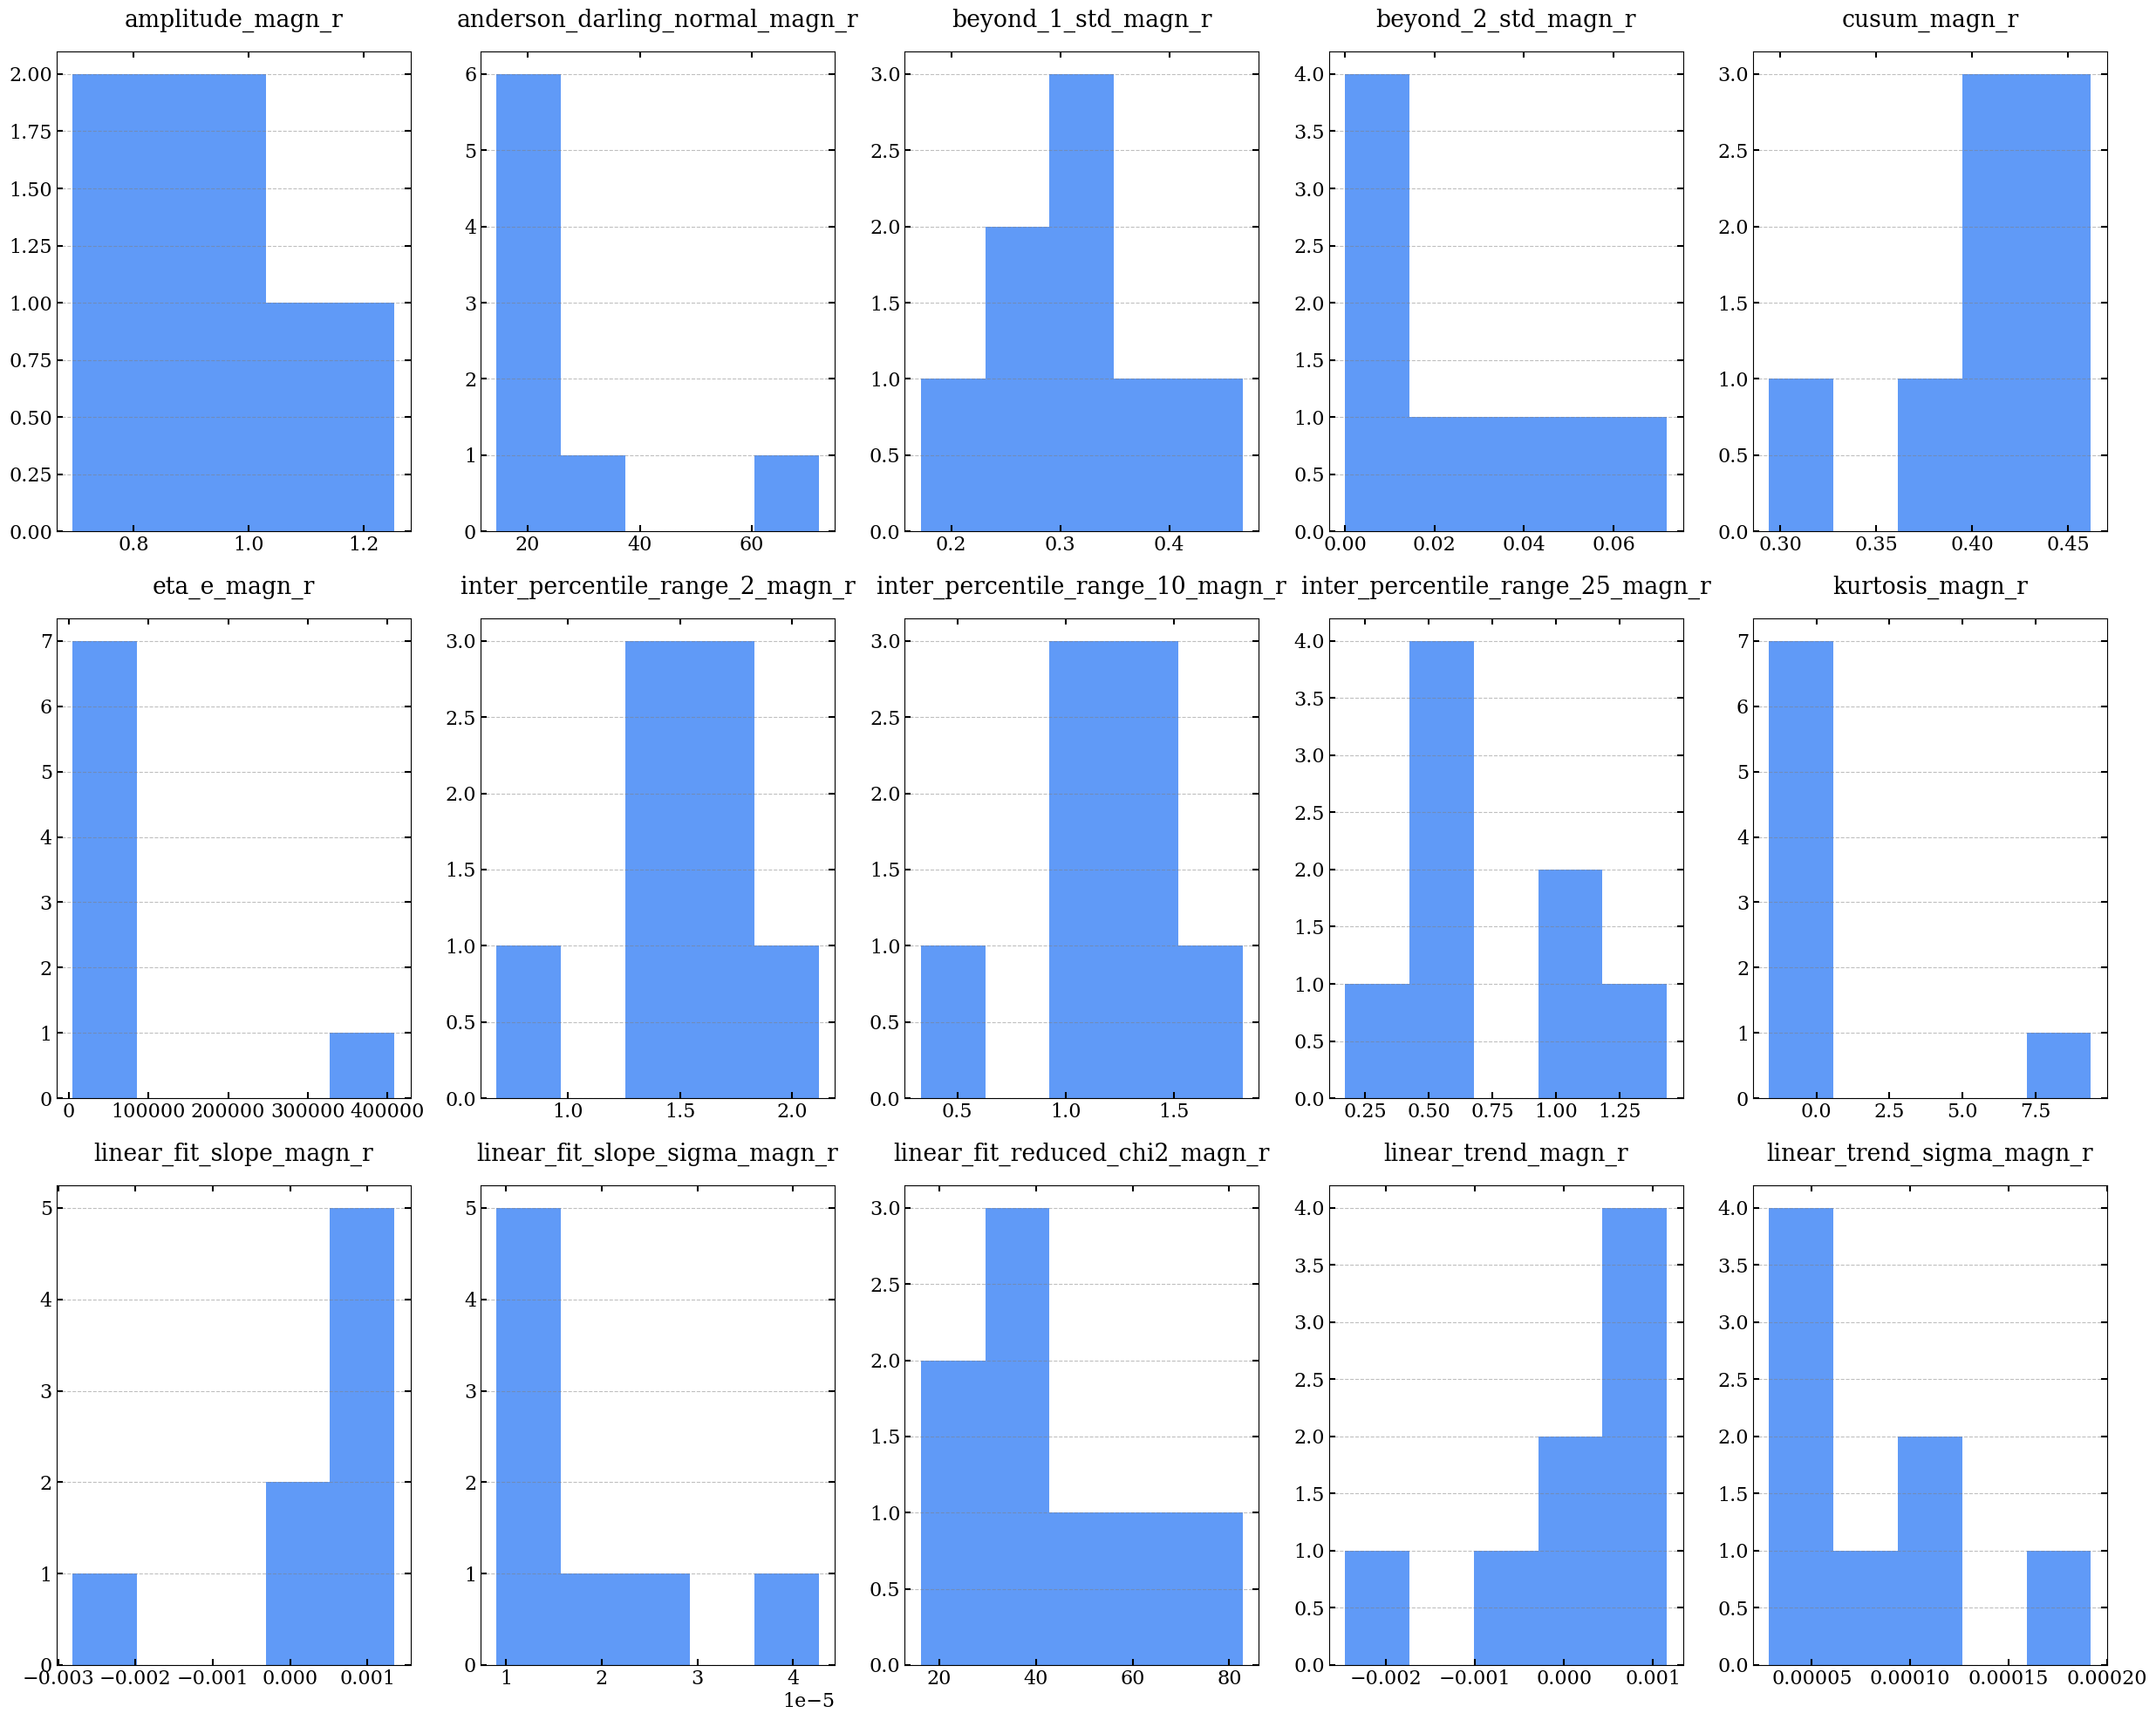

In [124]:
%matplotlib inline
fig = plt.figure(figsize=(25,20))
for i in range(15):
    
    plt.subplot(3, 5, i + 1)
    plt.hist(filter_features[:,i], bins=5, color='#609af7')
    plt.grid(axis='y', linestyle= "--",color='grey', zorder=0.1, alpha=0.5)
    plt.title(feature_name[i])
    plt.tight_layout()
    plt.savefig('/media3/majumder/zwaad/zwad/slsn_data/img1.png', dpi=fig.dpi)
plt.show()
